In [2]:
import os
import hashlib
import argparse
# from dotenv import load_dotenv

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

from scipy.stats import pearsonr

from skbio.diversity import alpha_diversity

import xgboost as xgb
import lightgbm as lgb

from bioblend.galaxy import GalaxyInstance


ModuleNotFoundError: No module named 'skbio'

# Kmer functions

In [4]:

def compute_stats_from_counts(kmer_file):
    # Load the k-mer counts file
    df = load_jellyfish_output(kmer_file)

    # Extract k-mer counts (assuming 'count' is the column name for counts)
    counts = df['count'].tolist()

    # Define the list of alpha diversity metrics to compute
    alpha_metrics = [
        "shannon",
        "simpson_d",
        "pielou_e",
        "berger_parker_d",
        "doubles",
        "chao1",
        "ace",
        "margalef",
        "menhinick",
        "observed_features",
        "singles",
        "brillouin_d",
        "enspie",
        "fisher_alpha",
        "hill",
        "inv_simpson",
        "kempton_taylor_q", 
        "renyi",
        "tsallis",
        "heip_e",
        "mcintosh_e",
        "simpson_e",
        "dominance",
        "gini_index",
        "mcintosh_d",
        "strong",
        "goods_coverage",
        "robbins",
    ]

    # Dictionary to store the results
    diversity_metrics = {}

    # Calculate and store each metric in the dictionary
    for metric_name in alpha_metrics:
        result = alpha_diversity(metric_name, counts)
        diversity_metrics[metric_name] = result[0]

    # add extra stats
    # Basic stats
    total_count = sum(counts)
    unique_kmers = sum(1 for c in counts if c > 0)
    mean_count = np.mean(counts)
    median_count = np.median(counts)
    max_count = max(counts)
    min_count = min(counts)
    std_count = np.std(counts)
    count_range = max_count - min_count
    num_singletons = counts.count(1)
    num_doubletons = counts.count(2)
    percent_singletons = (num_singletons / unique_kmers) * 100 if unique_kmers > 0 else 0

    # Add extra stats to dictionary
    diversity_metrics.update({
        'total_count': total_count,
        'unique_kmers': unique_kmers,
        'mean_count': mean_count,
        'median_count': median_count,
        'max_count': max_count,
        'min_count': min_count,
        'std_count': std_count,
        'count_range': count_range,
        'num_singletons': num_singletons,
        'num_doubletons': num_doubletons,
        'percent_singletons': percent_singletons,
    })

    # Convert the dictionary to a pandas DataFrame
    diversity_df = pd.DataFrame(list(diversity_metrics.items()), columns=["Metric", "Value"])
    diversity_df.set_index("Metric", inplace=True)
    
    return diversity_df

def hash_kmer(kmer, num_bins=100000):
    """Hashes a k-mer to one of num_bins using SHA256 and returns an integer index."""
    return int(hashlib.sha256(kmer.encode()).hexdigest(), 16) % num_bins

def load_jellyfish_output(file_path):
    """Loads k-mer counts from a Jellyfish dump file (.tsv)."""
    df = pd.read_csv(file_path, sep=" ", header=None, names=["kmer", "count"], skiprows=1)
    return df

def hash_and_sum_kmers(df, num_bins=100000):
    """Hashes k-mers into num_bins and sums counts using vectorized apply()."""
    # Hash all k-mers to their feature bin
    df["Feature_Index"] = df["kmer"].apply(lambda k: hash_kmer(k, num_bins))

    # Sum counts per bin
    hashed_counts = df.groupby("Feature_Index")["count"].sum()

    # Ensure all bins exist (fill missing ones with 0)
    hashed_df = pd.DataFrame({"Feature_Index": range(num_bins)})
    hashed_df = hashed_df.merge(hashed_counts, on="Feature_Index", how="left").fillna(0)

    hashed_df.set_index("Feature_Index", inplace = True)

    return hashed_df

def get_kmers_main(input_file, bins = 1000):
    #print(f"Loading Jellyfish k-mer counts from {input_file}...")
    df = load_jellyfish_output(input_file)

    #print(f"Hashing {len(df)} k-mers into 100,000 bins and summing counts (vectorized)...")
    hashed_df = hash_and_sum_kmers(df, num_bins=bins)

    # print(f"Saving hashed counts to {output_file}...")
    return(hashed_df)

# Read metadata

In [5]:
merged_df = pd.read_csv("input/updated_mgnify_assemblies_stats_v3.15.3_metaspades_subset.csv", sep=",")
merged_df.shape

(300, 13)

## Get the stats from Galaxy histroy using the tag `kmer-benchmark-stats`

In [10]:
# Initialize Galaxy connection (replace with your actual API key)

load_dotenv()
galaxy_key =  os.getenv("GALAXY_API") #store locally in .env file

gi = GalaxyInstance(url='https://usegalaxy.eu/', key=galaxy_key)

# Define the history ID (replace with the actual history ID you're working with)
history_id = 'adc86259aeafc341'
collection_tag = 'name:kmer-benchmark-stats'

# Step 1: Get the history's contents, including datasets
history_contents = gi.histories.show_history(history_id, contents=True)

name_size_mapping = {}

# Step 2: Loop through each item in the history to find collections and datasets with the specific tag
for item in history_contents:
    # Check if the item is a collection (type == 'dataset_collection')
    if item['type'] == 'collection':
        # Step 3: Fetch the collection's details using its ID
        collection_id = item['id']
        collection_info = gi.dataset_collections.show_dataset_collection(collection_id)

        print(collection_info['name'])

        if collection_tag in collection_info['tags']:
            print(collection_info['name'])

            for dataset in collection_info['elements']:
                print(dataset)

Split file on data 1: txt
Paired-end data (fastq-dump)
Single-end data (fastq-dump)
Paired-end data (fastq-dump) (re-organized)
FASTQ interlacer pairs from collection 1499
FASTQ interlacer singles from collection 1499
data 1498, data 1497, and others (filtered empty datasets)
data 2097, data 2095, and others (filtered failed datasets)
data 2394, data 2393, and others (filtered empty datasets)
data 2096, data 2094, and others (filtered failed datasets)
data 2753, data 2752, and others (filtered empty datasets)
data 2456, data 2455, and others (merged)
jellyfish on collection 3297: jellyfish db text
jellyfish on collection 3297: jellyfish db text
jellyfish on collection 3297: jellyfish db text
jellyfish on collection 3297: jellyfish db text
Kmer2Stats: kmer statistics


# Get the file size of the read files from the histroy (using the kmer-benchmark tag) - tag the interlaced fastq files, which should be approx. what Galaxy sees as input size

In [54]:
# Initialize Galaxy connection (replace with your actual API key)

load_dotenv()
galaxy_key =  os.getenv("GALAXY_API") #store locally in .env file

gi = GalaxyInstance(url='https://usegalaxy.eu/', key=galaxy_key)

# Define the history ID (replace with the actual history ID you're working with)
history_id = 'adc86259aeafc341'
collection_tag = 'name:kmer-benchmark'

# Step 1: Get the history's contents, including datasets
history_contents = gi.histories.show_history(history_id, contents=True)

name_size_mapping = {}

# Step 2: Loop through each item in the history to find collections and datasets with the specific tag
for item in history_contents:
    # Check if the item is a collection (type == 'dataset_collection')
    if item['type'] == 'collection':
        # Step 3: Fetch the collection's details using its ID
        collection_id = item['id']
        collection_info = gi.dataset_collections.show_dataset_collection(collection_id)

        if collection_tag in collection_info['tags']:
            #print(collection_info['name'])

            for dataset in collection_info['elements']:
                # print(dataset)
                filename = dataset['element_identifier']
                file_size = dataset['object']['file_size']  # File size in bytes
                print(filename)
                print(file_size)

                name_size_mapping[filename] = file_size

print(name_size_mapping)

ERR9581643
3295915885
SRR21856512
4179152943
SRR21856491
5408817563
SRR21856508
4226492791
SRR21856496
4930425317
SRR21856489
4393417282
SRR21856514
2013098427
SRR21856497
4054590470
SRR21856505
4344613778
SRR21856503
3525793496
SRR1611146
5977356076
SRR21856499
4164440401
ERR594345
31835132881
ERR3586788
4904191615
SRR12480233
2627629499
SRR12479866
3107315139
SRR13122284
1910431849
SRR17458616
1512957092
SRR12480292
2165453893
ERR594348
23090874794
SRR1522964
19444022604
SRR12480158
1558445782
ERR594336
35090026760
SRR12480362
3783190530
SRR13485158
1021853691
SRR17458619
1415024572
ERR9752702
2061112479
ERR8263081
3618832970
ERR9581642
3878696519
ERR9752724
1732378537
ERR9527534
4763030403
ERR9578590
7939316984
ERR9527526
5641835080
SRR25008561
3467124296
ERR8263091
7210898233
ERR9527528
5453528327
SRR25008570
3959736287
ERR9752742
1505223512
SRR25008539
3762747716
ERR9752757
1553081942
SRR25008557
3932651026
SRR25008559
5034053425
SRR25008571
4388883782
SRR25008579
3911477307
SRR25

# Get kmer stats

In [55]:
folder = "input/subset_3.15.3_metaspades/5mers"

stats_dfs = []
file_names = []

# Iterate over each file in the folder
for sample in os.listdir(folder):
    file_path = os.path.join(folder, sample)
    # kmer_hash = get_kmers_main(file_path, bins=600)
    stats = compute_stats_from_counts(file_path)

    # Extract the filename without extension
    file_name = os.path.splitext(sample)[0]

    # Rename the "counts" column to the filename
    # kmer_hash = kmer_hash.rename(columns={"count": file_name})
    stats = stats.rename(columns={"Value": file_name})

    #print(kmer_hash)
    # kmer_dfs.append(kmer_hash)
    stats_dfs.append(stats)

# Merge all DataFrames side by side using the filenames as column headers
stats_X = pd.concat(stats_dfs, axis=1).T

# Add file sizes to the stats_X DataFrame based on the index (which is the filename)
stats_X["file_size"] = stats_X.index.map(name_size_mapping)

# Display the merged DataFrame
print(stats_X.head())

/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/skbio/diversity/alpha/_base.py:822: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((N - S + 1) ** 2 + S - 1)
/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/skbio/diversity/alpha/_base.py:822: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((N - S + 1) ** 2 + S - 1)
/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/skbio/diversity/alpha/_base.py:822: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((N - S + 1) ** 2 + S - 1)
/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/skbio/diversity/alpha/_base.py:822: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((N - S + 1) ** 2 + S - 1)
/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/skbio/diversity/alpha/_base.py:822: RuntimeWarning: invalid value encountered in sqrt
  denominator = np.sqrt((N - S + 1) ** 2 + S - 1)
/home/paul/miniconda3/envs/ML/

Metric        shannon  simpson_d  pielou_e  berger_parker_d  doubles  chao1  \
SRR1611146   6.127422   0.002427  0.982530         0.007554      0.0  511.0   
SRR18243786  6.176878   0.002186  0.990461         0.004483      0.0  511.0   
ERR5032745   6.177165   0.002201  0.990507         0.004511      0.0  511.0   
ERR9752780   6.063069   0.002750  0.972211         0.009226      0.0  511.0   
ERR4398757   6.170971   0.002216  0.989513         0.005070      0.0  511.0   

Metric         ace   margalef  menhinick  observed_features  ...  \
SRR1611146   511.0  22.547197   0.006262              511.0  ...   
SRR18243786  511.0  22.646229   0.006580              511.0  ...   
ERR5032745   511.0  23.871352   0.011727              511.0  ...   
ERR9752780   511.0  23.261588   0.008863              511.0  ...   
ERR4398757   511.0  22.313092   0.005561              511.0  ...   

Metric         mean_count  median_count   max_count  min_count     std_count  \
SRR1611146   1.303111e+07    1213876

In [56]:
stats_X.to_csv("updated_mgnify_assemblies_stats_v3.15.3_metaspades_kmer_stats.csv")
stats_X.head()

Metric,shannon,simpson_d,pielou_e,berger_parker_d,doubles,chao1,ace,margalef,menhinick,observed_features,...,mean_count,median_count,max_count,min_count,std_count,count_range,num_singletons,num_doubletons,percent_singletons,file_size
SRR1611146,6.127422,0.002427,0.982530,0.007554,0.0,511.0,511.0,22.547197,0.006262,511.0,...,1.303111e+07,12138761.0,50298292.0,2084592.0,6.386785e+06,48213700.0,0.0,0.0,0.0,5977356076
SRR18243786,6.176878,0.002186,0.990461,0.004483,0.0,511.0,511.0,22.646229,0.006580,511.0,...,1.180385e+07,11833162.0,27039017.0,1019339.0,4.040586e+06,26019678.0,0.0,0.0,0.0,2612473254
ERR5032745,6.177165,0.002201,0.990507,0.004511,0.0,511.0,511.0,23.871352,0.011727,511.0,...,3.715973e+06,3455732.0,8564985.0,1286469.0,1.312721e+06,7278516.0,0.0,0.0,0.0,791809388
ERR9752780,6.063069,0.002750,0.972211,0.009226,0.0,511.0,511.0,23.261588,0.008863,511.0,...,6.505685e+06,5340032.0,30672063.0,982411.0,4.141469e+06,29689652.0,0.0,0.0,0.0,1719291408
ERR4398757,6.170971,0.002216,0.989513,0.005070,0.0,511.0,511.0,22.313092,0.005561,511.0,...,1.652140e+07,15847948.0,42799191.0,2011533.0,6.008734e+06,40787658.0,0.0,0.0,0.0,3697669370


# Align features and metadata

In [57]:
# Ensure 'Run' is the index in y
y = merged_df.loc[:, ["srr_id", "peak_mem_in_gbs"]].set_index("srr_id")

# Keep only common indices
common_indices = stats_X.index.intersection(y.index)

# Reindex both to have the same order
# kmers_X = kmers_X.loc[common_indices].sort_index()
stats_X = stats_X.loc[common_indices].sort_index()
y = y.loc[common_indices].sort_index()

# Print to check alignment
# print(kmers_X.shape)
stats_X = stats_X.fillna(0)
print(stats_X.shape)
print(y.shape)


(295, 40)
(295, 1)


# Correlate stats with peak_mem_in_gbs

/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


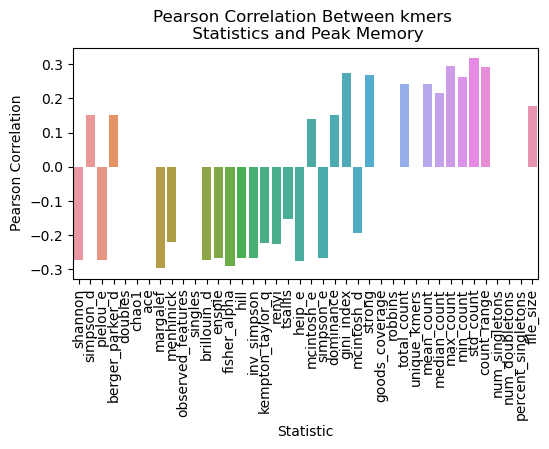

In [58]:
# Compute the Pearson correlation between each feature in stats_X and y
correlations = stats_X.corrwith(y["peak_mem_in_gbs"])

# Plot the correlations as a bar chart
plt.figure(figsize=(6, 3))
sns.barplot(x=correlations.index, y=correlations.values)
plt.title("Pearson Correlation Between kmers \n Statistics and Peak Memory")
plt.xlabel("Statistic")
plt.ylabel("Pearson Correlation")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# Plot performance for individual features and models

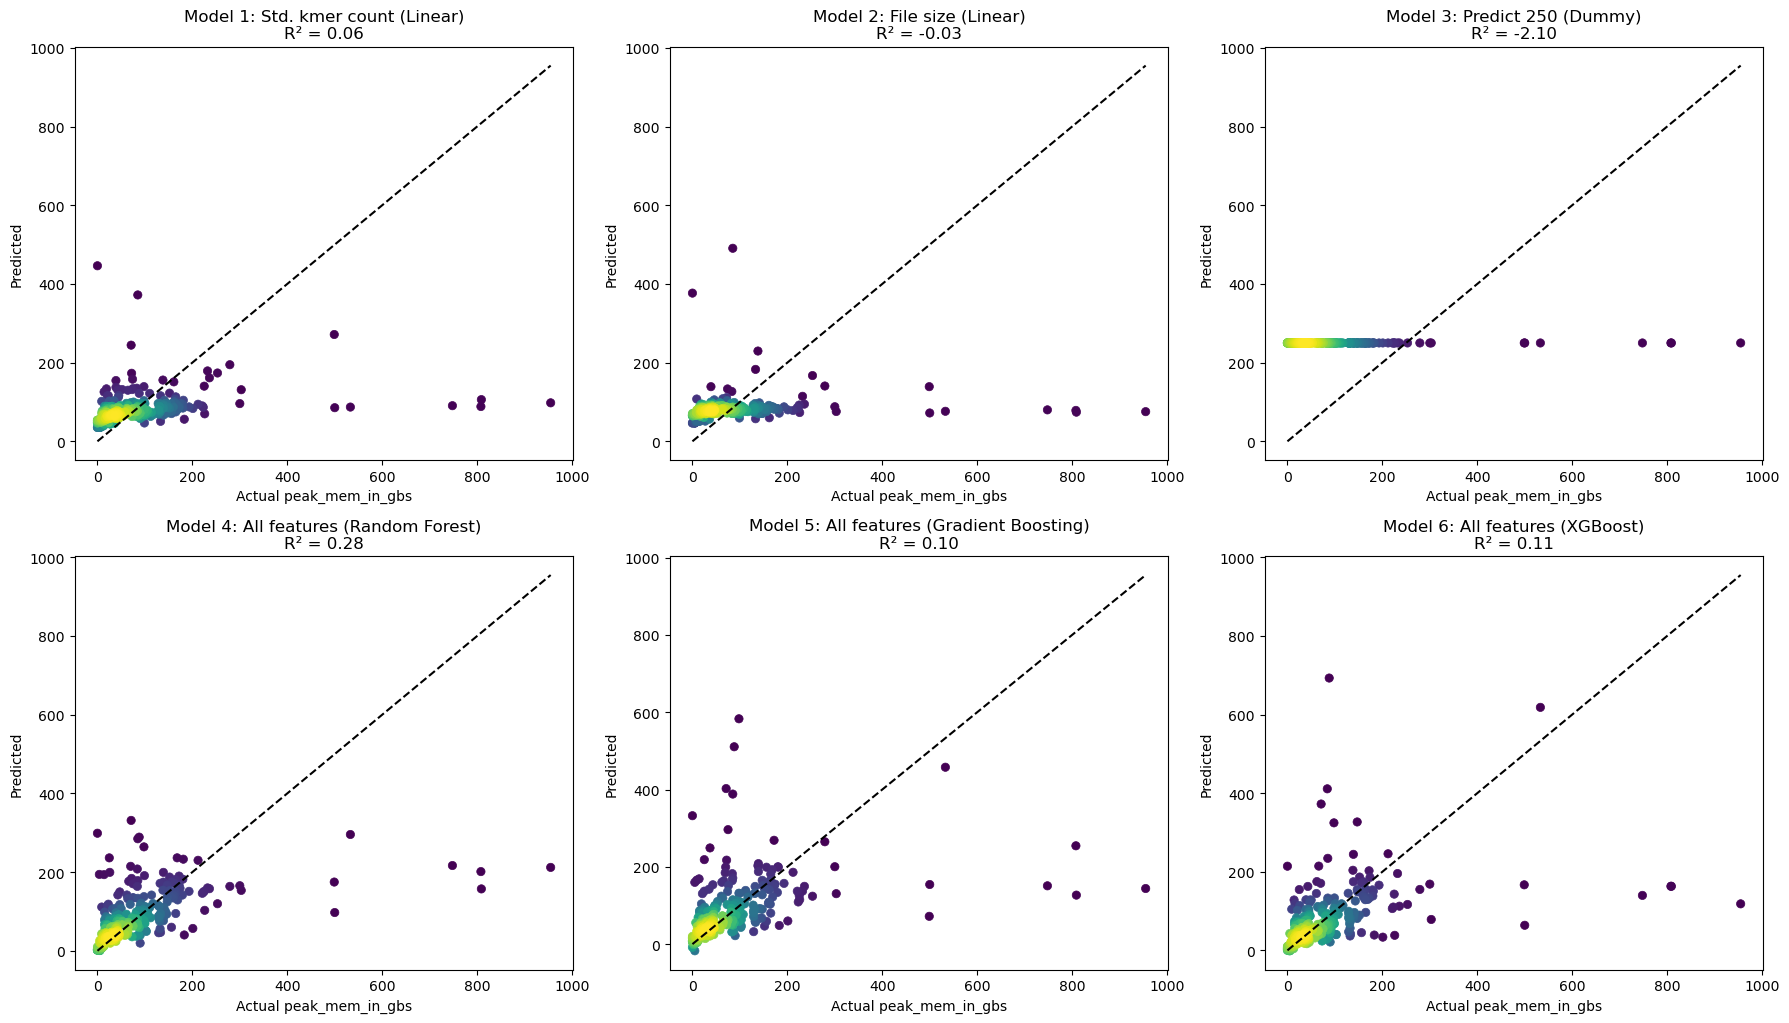

In [64]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score
import xgboost as xgb
from scipy.stats import gaussian_kde

# Fill NA with 0
stats_X = stats_X.fillna(0)

# Target
y_values = y["peak_mem_in_gbs"]

# Feature sets
features_1 = ["std_count"]
features_2 = ["file_size"]
features_all = stats_X.columns.tolist()

# Model list: (title, features, model_instance)
models = [
    ("Model 1: Std. kmer count (Linear)", features_1, LinearRegression()),
    ("Model 2: File size (Linear)", features_2, LinearRegression()),
    ("Model 3: Predict 250 (Dummy)", features_all, DummyRegressor(strategy="constant", constant=250)),
    ("Model 4: All features (Random Forest)", features_all, RandomForestRegressor(random_state=42)),
    ("Model 5: All features (Gradient Boosting)", features_all, GradientBoostingRegressor(random_state=42)),
    ("Model 6: All features (XGBoost)", features_all, xgb.XGBRegressor(random_state=42, verbosity=0)),
]

# Use KFold for consistent splitting across models
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Plot setup
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for idx, (title, feat_list, model) in enumerate(models):
    X = stats_X[feat_list]

    # Get cross-validated predictions for all samples
    y_pred = cross_val_predict(model, X, y_values, cv=cv)

    ax = axes[idx]

    # Calculate density for coloring
    xy = np.vstack([y_values, y_pred])
    z = gaussian_kde(xy)(xy)

    # Sort points by density so densest points plot on top
    idx_sort = z.argsort()
    x_sorted, y_sorted, z_sorted = y_values.iloc[idx_sort], y_pred[idx_sort], z[idx_sort]

    sns.scatterplot(x=x_sorted, y=y_sorted, hue=z_sorted, palette="viridis", ax=ax, legend=False, edgecolor=None)
    ax.plot([y_values.min(), y_values.max()], [y_values.min(), y_values.max()], 'k--')
    ax.set_title(f"{title}\nR² = {r2_score(y_values, y_pred):.2f}")
    ax.set_xlabel("Actual peak_mem_in_gbs")
    ax.set_ylabel("Predicted")

# Hide any unused subplots
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# highlight model vs file size

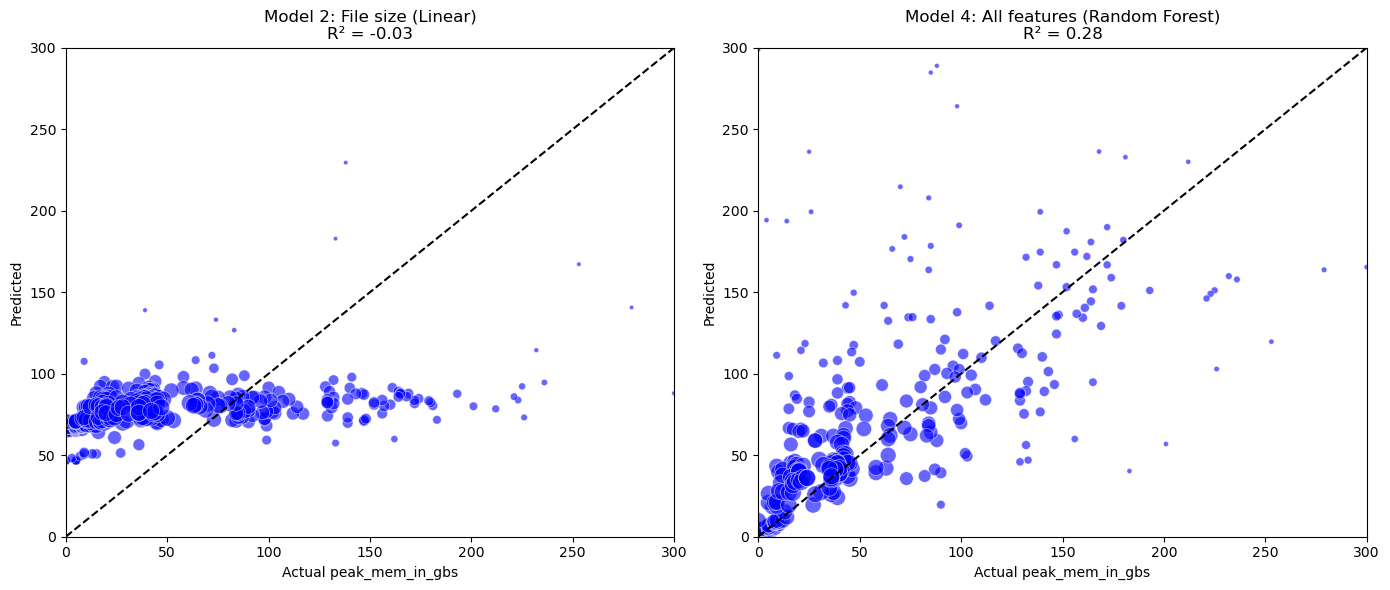

In [61]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde

# Fill NA with 0
stats_X = stats_X.fillna(0)

# Target
y_values = y["peak_mem_in_gbs"]

# Models to plot: File Size (Linear Regression) and Random Forest (all features)
models = [
    ("Model 2: File size (Linear)", ["file_size"], LinearRegression()),
    ("Model 4: All features (Random Forest)", stats_X.columns.tolist(), RandomForestRegressor(random_state=42)),
]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Plot setup
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (title, feat_list, model) in enumerate(models):
    X = stats_X[feat_list]

    # Get cross-validated predictions for all samples
    y_pred = cross_val_predict(model, X, y_values, cv=cv)

    ax = axes[idx]

    # Calculate density for sizing
    xy = np.vstack([y_values, y_pred])
    z = gaussian_kde(xy)(xy)

    # Sort points by density so densest points plot on top
    idx_sort = z.argsort()
    x_sorted, y_sorted, z_sorted = y_values.iloc[idx_sort], y_pred[idx_sort], z[idx_sort]

    # Scale sizes: normalize z for sizes between 10 and 150
    size_min, size_max = 10, 150
    sizes = size_min + (z_sorted - z_sorted.min()) / (z_sorted.max() - z_sorted.min()) * (size_max - size_min)

    scatter = ax.scatter(x_sorted, y_sorted, s=sizes, color='blue', alpha=0.6, edgecolors='w', linewidth=0.5)
    ax.plot([0, 300], [0, 300], 'k--')
    ax.set_title(f"{title}\nR² = {r2_score(y_values, y_pred):.2f}")
    ax.set_xlabel("Actual peak_mem_in_gbs")
    ax.set_ylabel("Predicted")
    ax.set_xlim(0, 300)
    ax.set_ylim(0, 300)

plt.tight_layout()
plt.show()


/home/paul/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


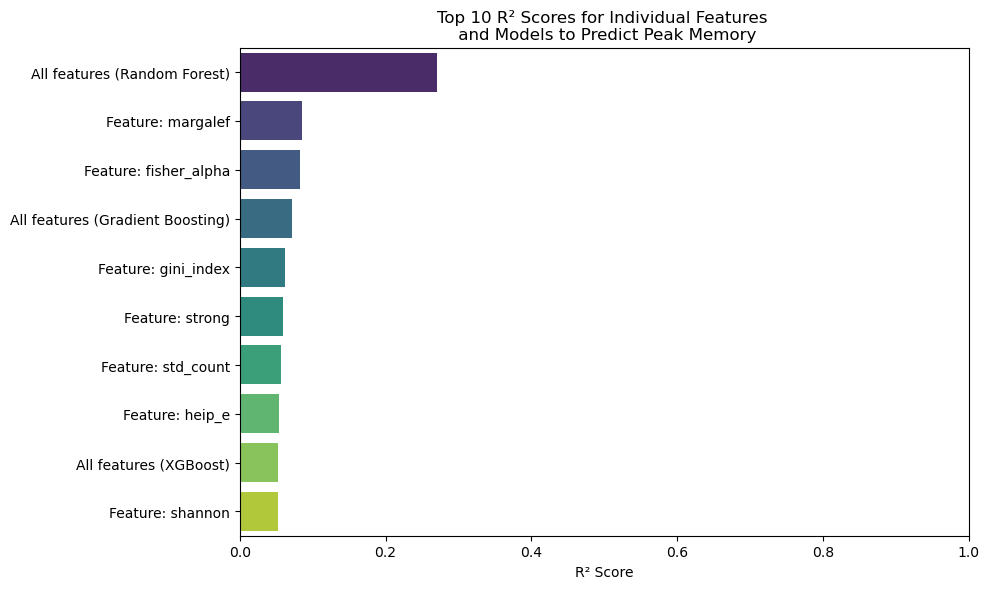

In [63]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb

# Fill NA with 0
stats_X = stats_X.fillna(0)

# Target
y_values = y["peak_mem_in_gbs"]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate R2 for each individual feature using Linear Regression with cross-validation
single_feature_r2 = {}
for feat in stats_X.columns:
    X = stats_X[[feat]]
    model = LinearRegression()
    scores = cross_val_score(model, X, y_values, cv=cv, scoring='r2')
    single_feature_r2[feat] = scores.mean()

# Predefined model list: (title, features, model_instance)
models = [
    ("Predict 250 (Dummy)", stats_X.columns.tolist(), DummyRegressor(strategy="constant", constant=250)),
    ("All features (Random Forest)", stats_X.columns.tolist(), RandomForestRegressor(random_state=42)),
    ("All features (Gradient Boosting)", stats_X.columns.tolist(), GradientBoostingRegressor(random_state=42)),
    ("All features (XGBoost)", stats_X.columns.tolist(), xgb.XGBRegressor(random_state=42, verbosity=0)),
]

# Evaluate R2 for all models with cross-validation
model_r2 = {}
for title, feat_list, model in models:
    X = stats_X[feat_list]
    scores = cross_val_score(model, X, y_values, cv=cv, scoring='r2')
    model_r2[title] = scores.mean()

# Combine all results
all_r2 = {**{f"Feature: {k}" : v for k, v in single_feature_r2.items()}, **model_r2}

# Sort results by R2 and keep top 10 only
top_10_r2 = dict(sorted(all_r2.items(), key=lambda item: item[1], reverse=True)[:10])

# Plot R2 scores in bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=list(top_10_r2.values()), y=list(top_10_r2.keys()), palette="viridis")
plt.xlabel("R² Score")
plt.title("Top 10 R² Scores for Individual Features \n and Models to Predict Peak Memory")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


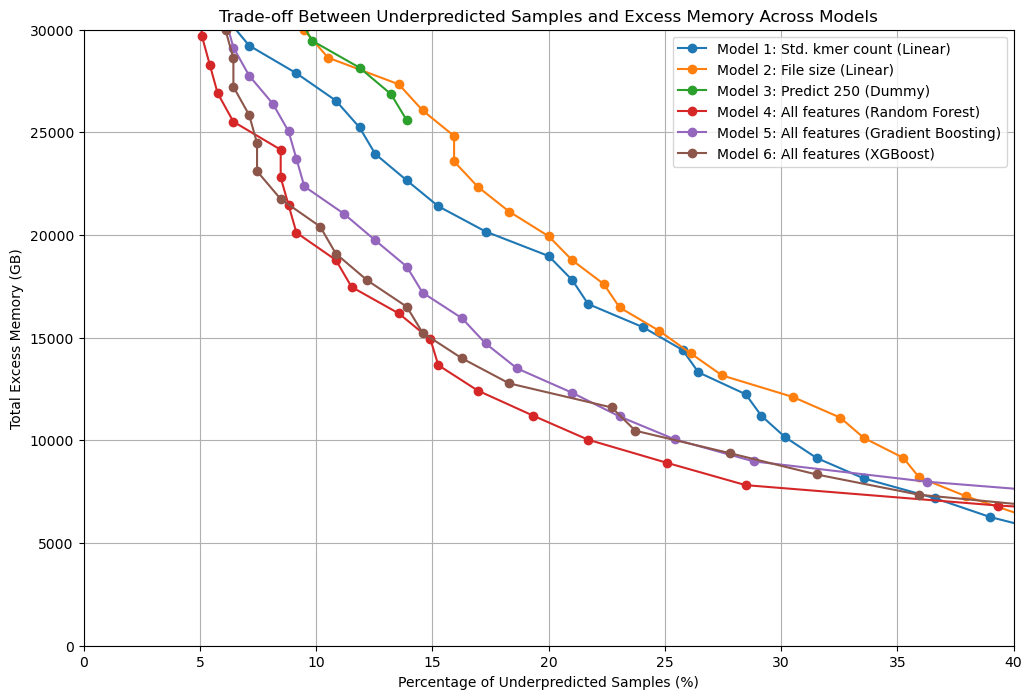

In [65]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, KFold
import xgboost as xgb

# Fill NA with 0
stats_X = stats_X.fillna(0)

# Target
y_values = y["peak_mem_in_gbs"]

# Feature sets
features_1 = ["std_count"]
features_2 = ["file_size"]
features_all = stats_X.columns.tolist()

# Model list: (title, features, model_instance)
models = [
    ("Model 1: Std. kmer count (Linear)", features_1, LinearRegression()),
    ("Model 2: File size (Linear)", features_2, LinearRegression()),
    ("Model 3: Predict 250 (Dummy)", features_all, DummyRegressor(strategy="constant", constant=250)),
    ("Model 4: All features (Random Forest)", features_all, RandomForestRegressor(random_state=42)),
    ("Model 5: All features (Gradient Boosting)", features_all, GradientBoostingRegressor(random_state=42)),
    ("Model 6: All features (XGBoost)", features_all, xgb.XGBRegressor(random_state=42, verbosity=0)),
]

adjustment_steps = np.arange(-100, 101, 5)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

plt.figure(figsize=(12, 8))

for title, feat_list, model in models:
    X = stats_X[feat_list]
    
    # Get cross-validated predictions for all samples
    y_pred_base = cross_val_predict(model, X, y_values, cv=cv)
    
    underpred_percent_list = []
    excess_memory_list = []
    n_samples = len(y_values)
    
    for adj in adjustment_steps:
        y_pred_adj = y_pred_base + adj
        
        under_pred_mask = y_pred_adj < y_values
        under_pred_count = np.sum(under_pred_mask)
        under_pred_percent = (under_pred_count / n_samples) * 100
        
        excess_memory = y_pred_adj[~under_pred_mask] - y_values[~under_pred_mask]
        total_excess_memory = np.sum(excess_memory)
        
        underpred_percent_list.append(under_pred_percent)
        excess_memory_list.append(total_excess_memory)
    
    plt.plot(underpred_percent_list, excess_memory_list, label=title, marker='o')

plt.xlabel("Percentage of Underpredicted Samples (%)")
plt.ylabel("Total Excess Memory (GB)")
plt.title("Trade-off Between Underpredicted Samples and Excess Memory Across Models")
plt.legend()
plt.grid(True)
plt.xlim(0, 40)
plt.ylim(0, 30000)
plt.show()


In [66]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold

# Fill NA with 0
stats_X = stats_X.fillna(0)

# Target
y_values = y["peak_mem_in_gbs"]

# Models to compare
models = {
    "File size (Linear)": (["file_size"], LinearRegression()),
    "Random Forest (All features)": (stats_X.columns.tolist(), RandomForestRegressor(random_state=42)),
}

adjustment_steps = np.arange(-100, 101, 5)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results for 10% failure
excess_at_10_percent = {}

for title, (feat_list, model) in models.items():
    X = stats_X[feat_list]
    y_pred_base = cross_val_predict(model, X, y_values, cv=cv)
    n_samples = len(y_values)

    for adj in adjustment_steps:
        y_pred_adj = y_pred_base + adj
        under_pred_mask = y_pred_adj < y_values
        under_pred_percent = np.sum(under_pred_mask) / n_samples * 100
        
        if np.isclose(under_pred_percent, 10, atol=1):  # allow ±1% tolerance
            excess_memory = y_pred_adj[~under_pred_mask] - y_values[~under_pred_mask]
            total_excess_memory = np.sum(excess_memory)
            excess_at_10_percent[title] = total_excess_memory
            break

# Compute difference
diff = excess_at_10_percent["Random Forest (All features)"] - excess_at_10_percent["File size (Linear)"]

print(f"Total excess memory at ~10% underprediction failure:")
print(f" - File size (Linear): {excess_at_10_percent['File size (Linear)']:.2f} GB")
print(f" - Random Forest (All features): {excess_at_10_percent['Random Forest (All features)']:.2f} GB")
print(f"Difference (RF - File size): {diff:.2f} GB")


Total excess memory at ~10% underprediction failure:
 - File size (Linear): 28641.35 GB
 - Random Forest (All features): 18784.58 GB
Difference (RF - File size): -9856.77 GB


#  get formula of linear model for TPV
# todo adapt to new rule

Adjusted formula: peak_mem_in_gbs ≈ 199.5274 + 0.0000 * file_size
Total memory saved by adjusted regression vs dynamic baseline: 39529.80 GB


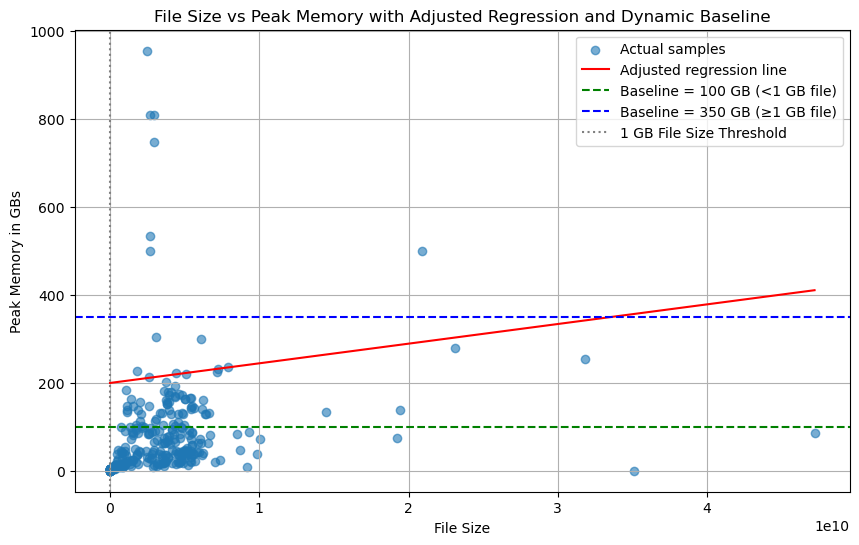

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, KFold

# Fill NA with 0
stats_X = stats_X.fillna(0)
y_values = y["peak_mem_in_gbs"]

# Feature for file size linear model
features_2 = ["file_size"]
X = stats_X[features_2]

# Model
model = LinearRegression()

# Cross-validated predictions (5-fold)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_base = cross_val_predict(model, X, y_values, cv=cv)

n_samples = len(y_values)
adjustment_steps = np.arange(-100, 201, 5)

# Find adjustment for <5% underprediction
best_adj = None
for adj in adjustment_steps:
    y_pred_adj = y_pred_base + adj
    under_pred_mask = y_pred_adj < y_values
    under_pred_percent = (np.sum(under_pred_mask) / n_samples) * 100

    if under_pred_percent < 5:
        best_adj = adj
        break

if best_adj is None:
    print("No adjustment found that keeps underprediction below 5%. Using no adjustment.")
    best_adj = 0

# Fit model on full data to get coefficients for formula
model.fit(X, y_values)
intercept_adj = model.intercept_ + best_adj
coef = model.coef_[0]

print(f"Adjusted formula: peak_mem_in_gbs ≈ {intercept_adj:.4f} + {coef:.4f} * file_size")

# Predict using the adjusted model
y_pred_full = intercept_adj + coef * X["file_size"]

# Dynamic baseline: 100 GB if file_size < 1, else 350 GB
baseline = np.where(X["file_size"] < 1, 100, 350)

# Compute memory saved
memory_saved = np.maximum(0, baseline - y_pred_full)
total_saved_memory = memory_saved.sum()

print(f"Total memory saved by adjusted regression vs dynamic baseline: {total_saved_memory:.2f} GB")

# Plot samples and adjusted regression line
plt.figure(figsize=(10, 6))
plt.scatter(X["file_size"], y_values, alpha=0.6, label="Actual samples")

# Regression line
x_vals = np.linspace(X["file_size"].min(), X["file_size"].max(), 100)
y_vals = intercept_adj + coef * x_vals
plt.plot(x_vals, y_vals, color="red", label="Adjusted regression line")

# Plot dynamic baseline lines
plt.axhline(y=100, color='green', linestyle='--', label="Baseline = 100 GB (<1 GB file)")
plt.axhline(y=350, color='blue', linestyle='--', label="Baseline = 350 GB (≥1 GB file)")

# Vertical marker for the 1 GB file size threshold
plt.axvline(x=1.0, color='gray', linestyle=':', label="1 GB File Size Threshold")

plt.xlabel("File Size")
plt.ylabel("Peak Memory in GBs")
plt.title("File Size vs Peak Memory with Adjusted Regression and Dynamic Baseline")
plt.legend()
plt.grid(True)
plt.show()
